# Model Testing


## Setup


In [1]:
from scripts.preprocessing.data_loader import get_train_test_splits, get_combined_dataset
from scripts.preprocessing.preprocessor import apply_minmax_scaling
from scripts.models.model_list import load_models
from scripts.models.model_testing import test_models
from IPython.display import display
from scripts.visualisations.plotting import plot_averaged_heatmap, plot_group_averaged_spatial_heatmap
from scripts.visualisations.helpers import rescale_features
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = get_train_test_splits(test_size=0.2)
X_train, y_train, train_scales = apply_minmax_scaling(X_train, y_train)
X_test, y_test, test_scales = apply_minmax_scaling(X_test, y_test)
df = get_combined_dataset(X_train, y_train, X_test, y_test)

TEST_SET, ALL_SINGLE_TARGET_MODELS, REFINED_SINGLE_TARGET_MODELS, ALL_MULTI_TARGET_MODELS, REFINED_MULTI_TARGET_MODELS = load_models()
print(f"Number of single-target models: {len(ALL_SINGLE_TARGET_MODELS)}")
print(f"Number of multi-target models: {len(ALL_MULTI_TARGET_MODELS)}")

Train years: 2015 to 2083
Test years: 2084 to 2100
Number of single-target models: 26
Number of multi-target models: 11


## Dataset

In [2]:
display(df)
display(df.describe())
display(df.info())

,x,y,bedrock_elevation,precipitation,air_temperature,ocean_temperature,year,distance_to_pole,bedrock_below_sea_level,temperature_difference,log_air_temperature,rolling_std_precipitation,rolling_std_air_temperature,air_temperature_low_45,set,ice_thickness,ice_velocity,ice_mask
0,0.28,1.0,0.118762,0.180874,0.795808,0.268660,0.0,1.000000,1.0,0.195877,0.816036,0.000000,0.000000,0.0,train,0.0,0.0,1.0
1,0.30,1.0,0.163009,0.175715,0.793057,0.258708,0.0,0.985824,1.0,0.197598,0.813495,0.000000,0.000000,0.0,train,0.0,0.0,1.0
2,0.32,1.0,0.042803,0.173047,0.791427,0.251029,0.0,0.972821,1.0,0.198422,0.811990,0.007757,0.010490,0.0,train,0.0,0.0,1.0
3,0.34,1.0,0.135461,0.178002,0.790789,0.245280,0.0,0.961037,1.0,0.198443,0.811400,0.004835,0.005541,0.0,train,0.0,0.0,1.0
4,0.36,1.0,0.087251,0.190951,0.790841,0.240754,0.0,0.950518,1.0,0.197891,0.811449,0.018024,0.001677,0.0,train,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194097,0.64,0.0,0.347665,0.592466,0.831212,0.272332,1.0,0.950518,1.0,0.167398,0.847265,0.054746,0.015050,0.0,test,0.0,0.0,1.0
194098,0.66,0.0,0.326669,0.557774,0.838175,0.285703,1.0,0.961037,1.0,0.162018,0.853679,0.041361,0.027430,0.0,test,0.0,0.0,1.0
194099,0.68,0.0,0.365826,0.535849,0.843655,0.296153,1.0,0.972821,1.0,0.157776,0.858719,0.065255,0.028774,0.0,test,0.0,0.0,1.0
194100,0.70,0.0,0.416587,0.533697,0.851775,0.315210,1.0,0.985824,1.0,0.151929,0.866176,0.030454,0.031585,0.0,test,0.0,0.0,1.0


,x,y,bedrock_elevation,precipitation,air_temperature,ocean_temperature,year,distance_to_pole,bedrock_below_sea_level,temperature_difference,log_air_temperature,rolling_std_precipitation,rolling_std_air_temperature,air_temperature_low_45,ice_thickness,ice_velocity,ice_mask
count,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000
mean,0.500000,0.500000,0.448466,0.227651,0.664751,0.300004,0.500000,0.654930,0.800904,0.334532,0.683837,0.060892,0.132858,0.450001,0.169265,0.002387,0.612915
std,0.268418,0.268418,0.248347,0.155997,0.269263,0.148372,0.295566,0.232295,0.399322,0.266910,0.264363,0.086349,0.152931,0.497495,0.254166,0.017803,0.478661
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.280000,0.280000,0.202051,0.073388,0.460199,0.193012,0.250000,0.491210,1.000000,0.122919,0.492621,0.012105,0.029670,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.515438,0.231066,0.790091,0.264870,0.500000,0.695639,1.000000,0.198799,0.810557,0.029775,0.075701,0.000000,0.000000,0.000000,1.000000
75%,0.720000,0.720000,0.662950,0.350513,0.877833,0.373267,0.750000,0.849223,1.000000,0.534037,0.890761,0.072282,0.171213,1.000000,0.355686,0.000276,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194102 entries, 0 to 194101
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   x                            194102 non-null  float64
 1   y                            194102 non-null  float64
 2   bedrock_elevation            194102 non-null  float64
 3   precipitation                194102 non-null  float64
 4   air_temperature              194102 non-null  float64
 5   ocean_temperature            194102 non-null  float64
 6   year                         194102 non-null  float64
 7   distance_to_pole             194102 non-null  float64
 8   bedrock_below_sea_level      194102 non-null  float64
 9   temperature_difference       194102 non-null  float64
 10  log_air_temperature          194102 non-null  float64
 11  rolling_std_precipitation    194102 non-null  float64
 12  rolling_std_air_temperature  194102 non-null  float64
 13 

None

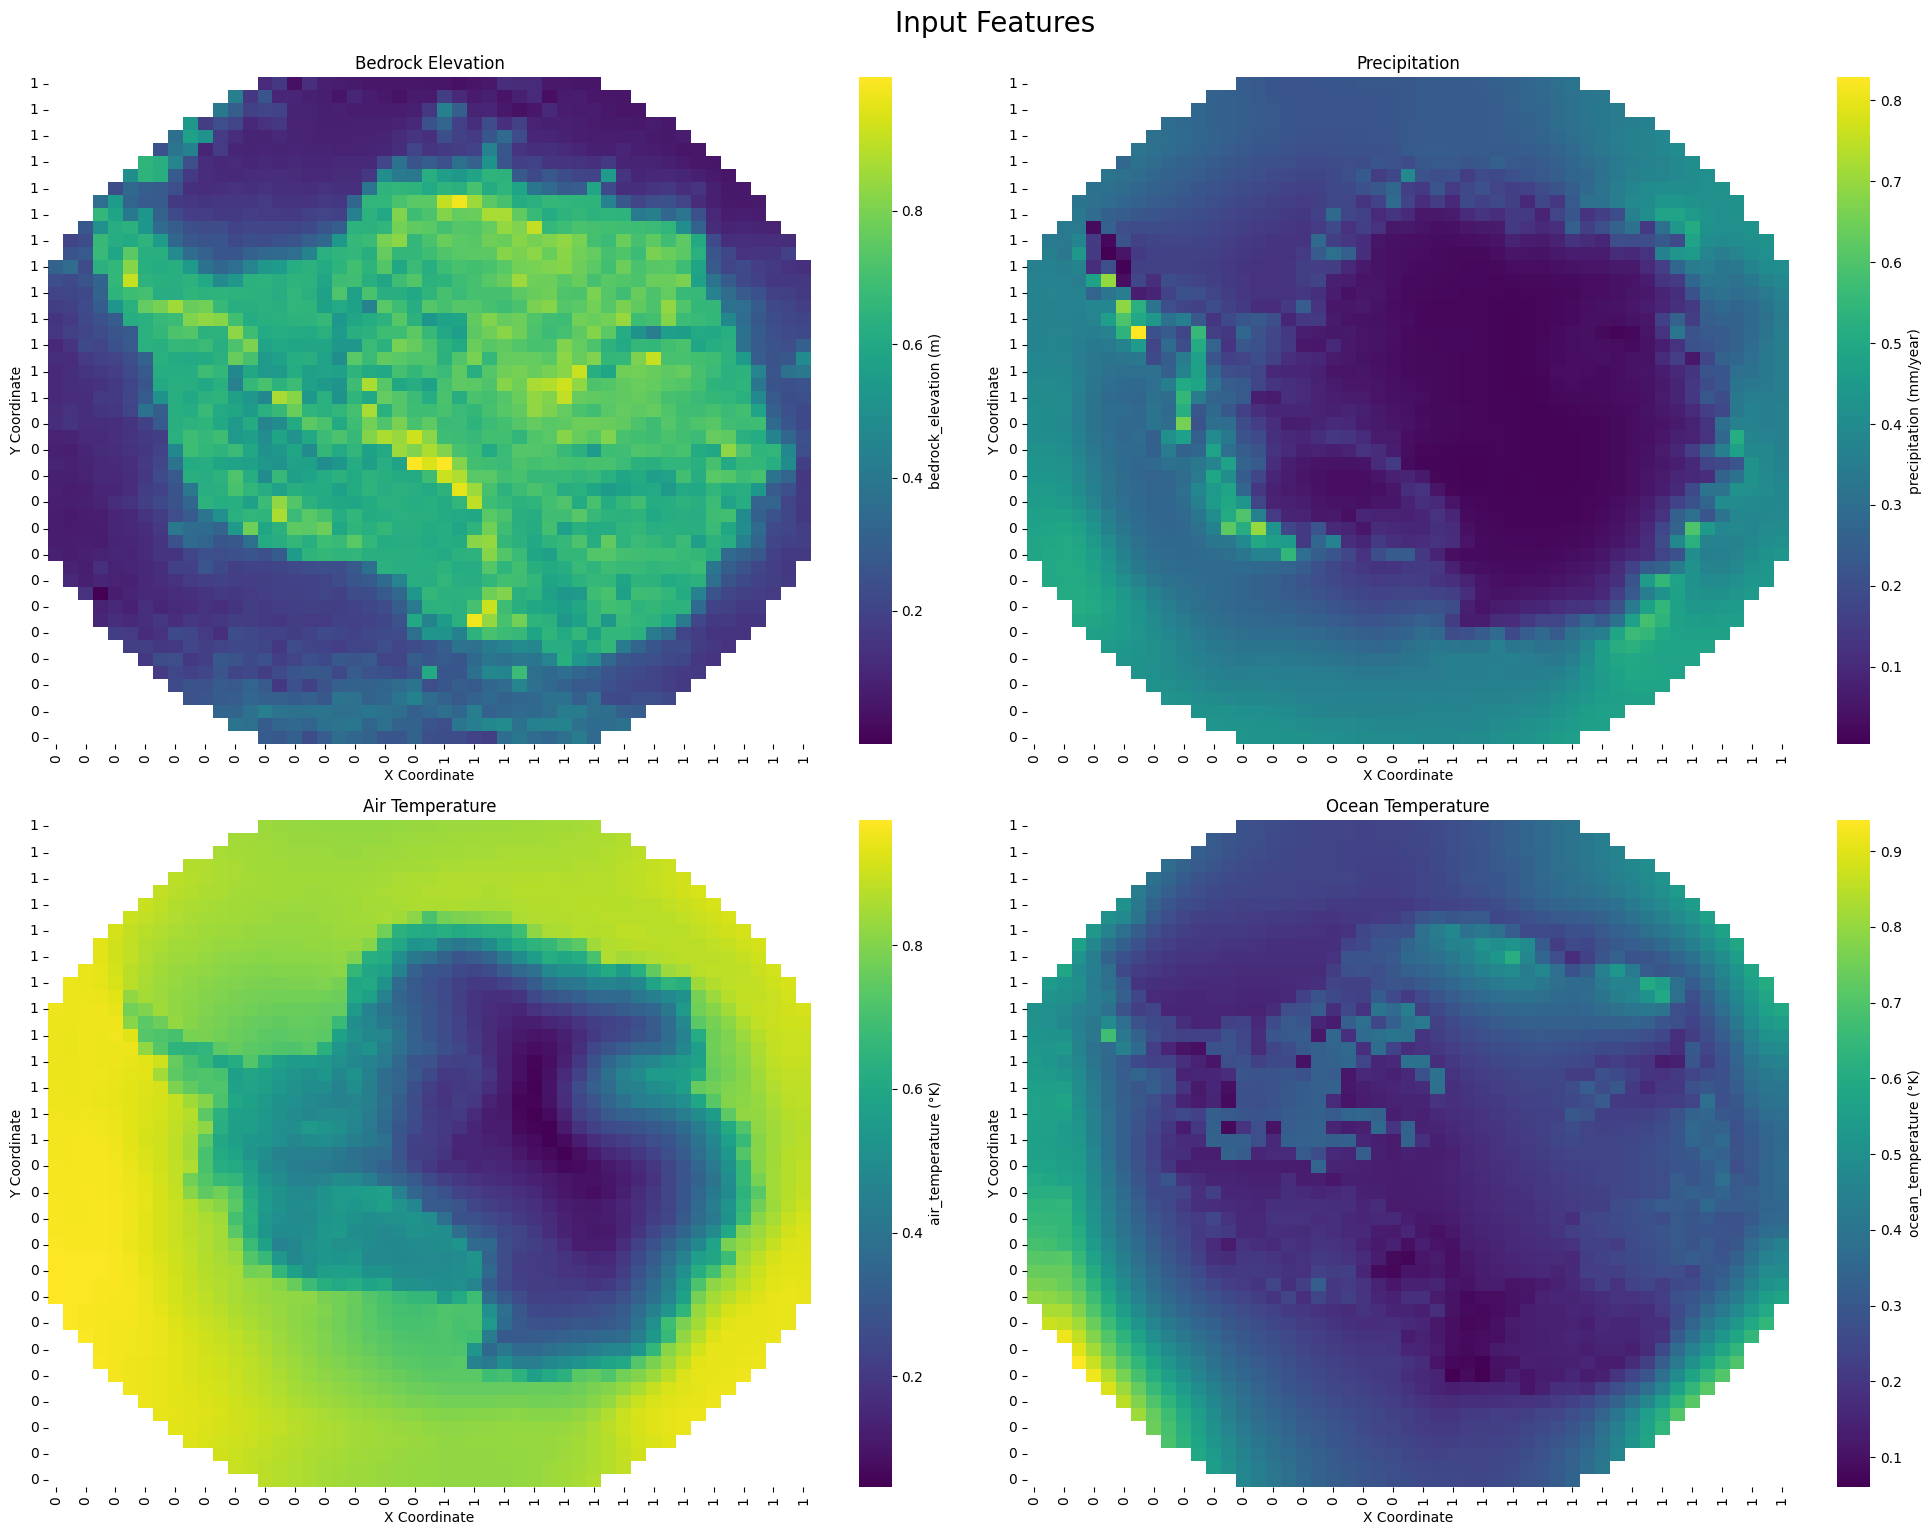

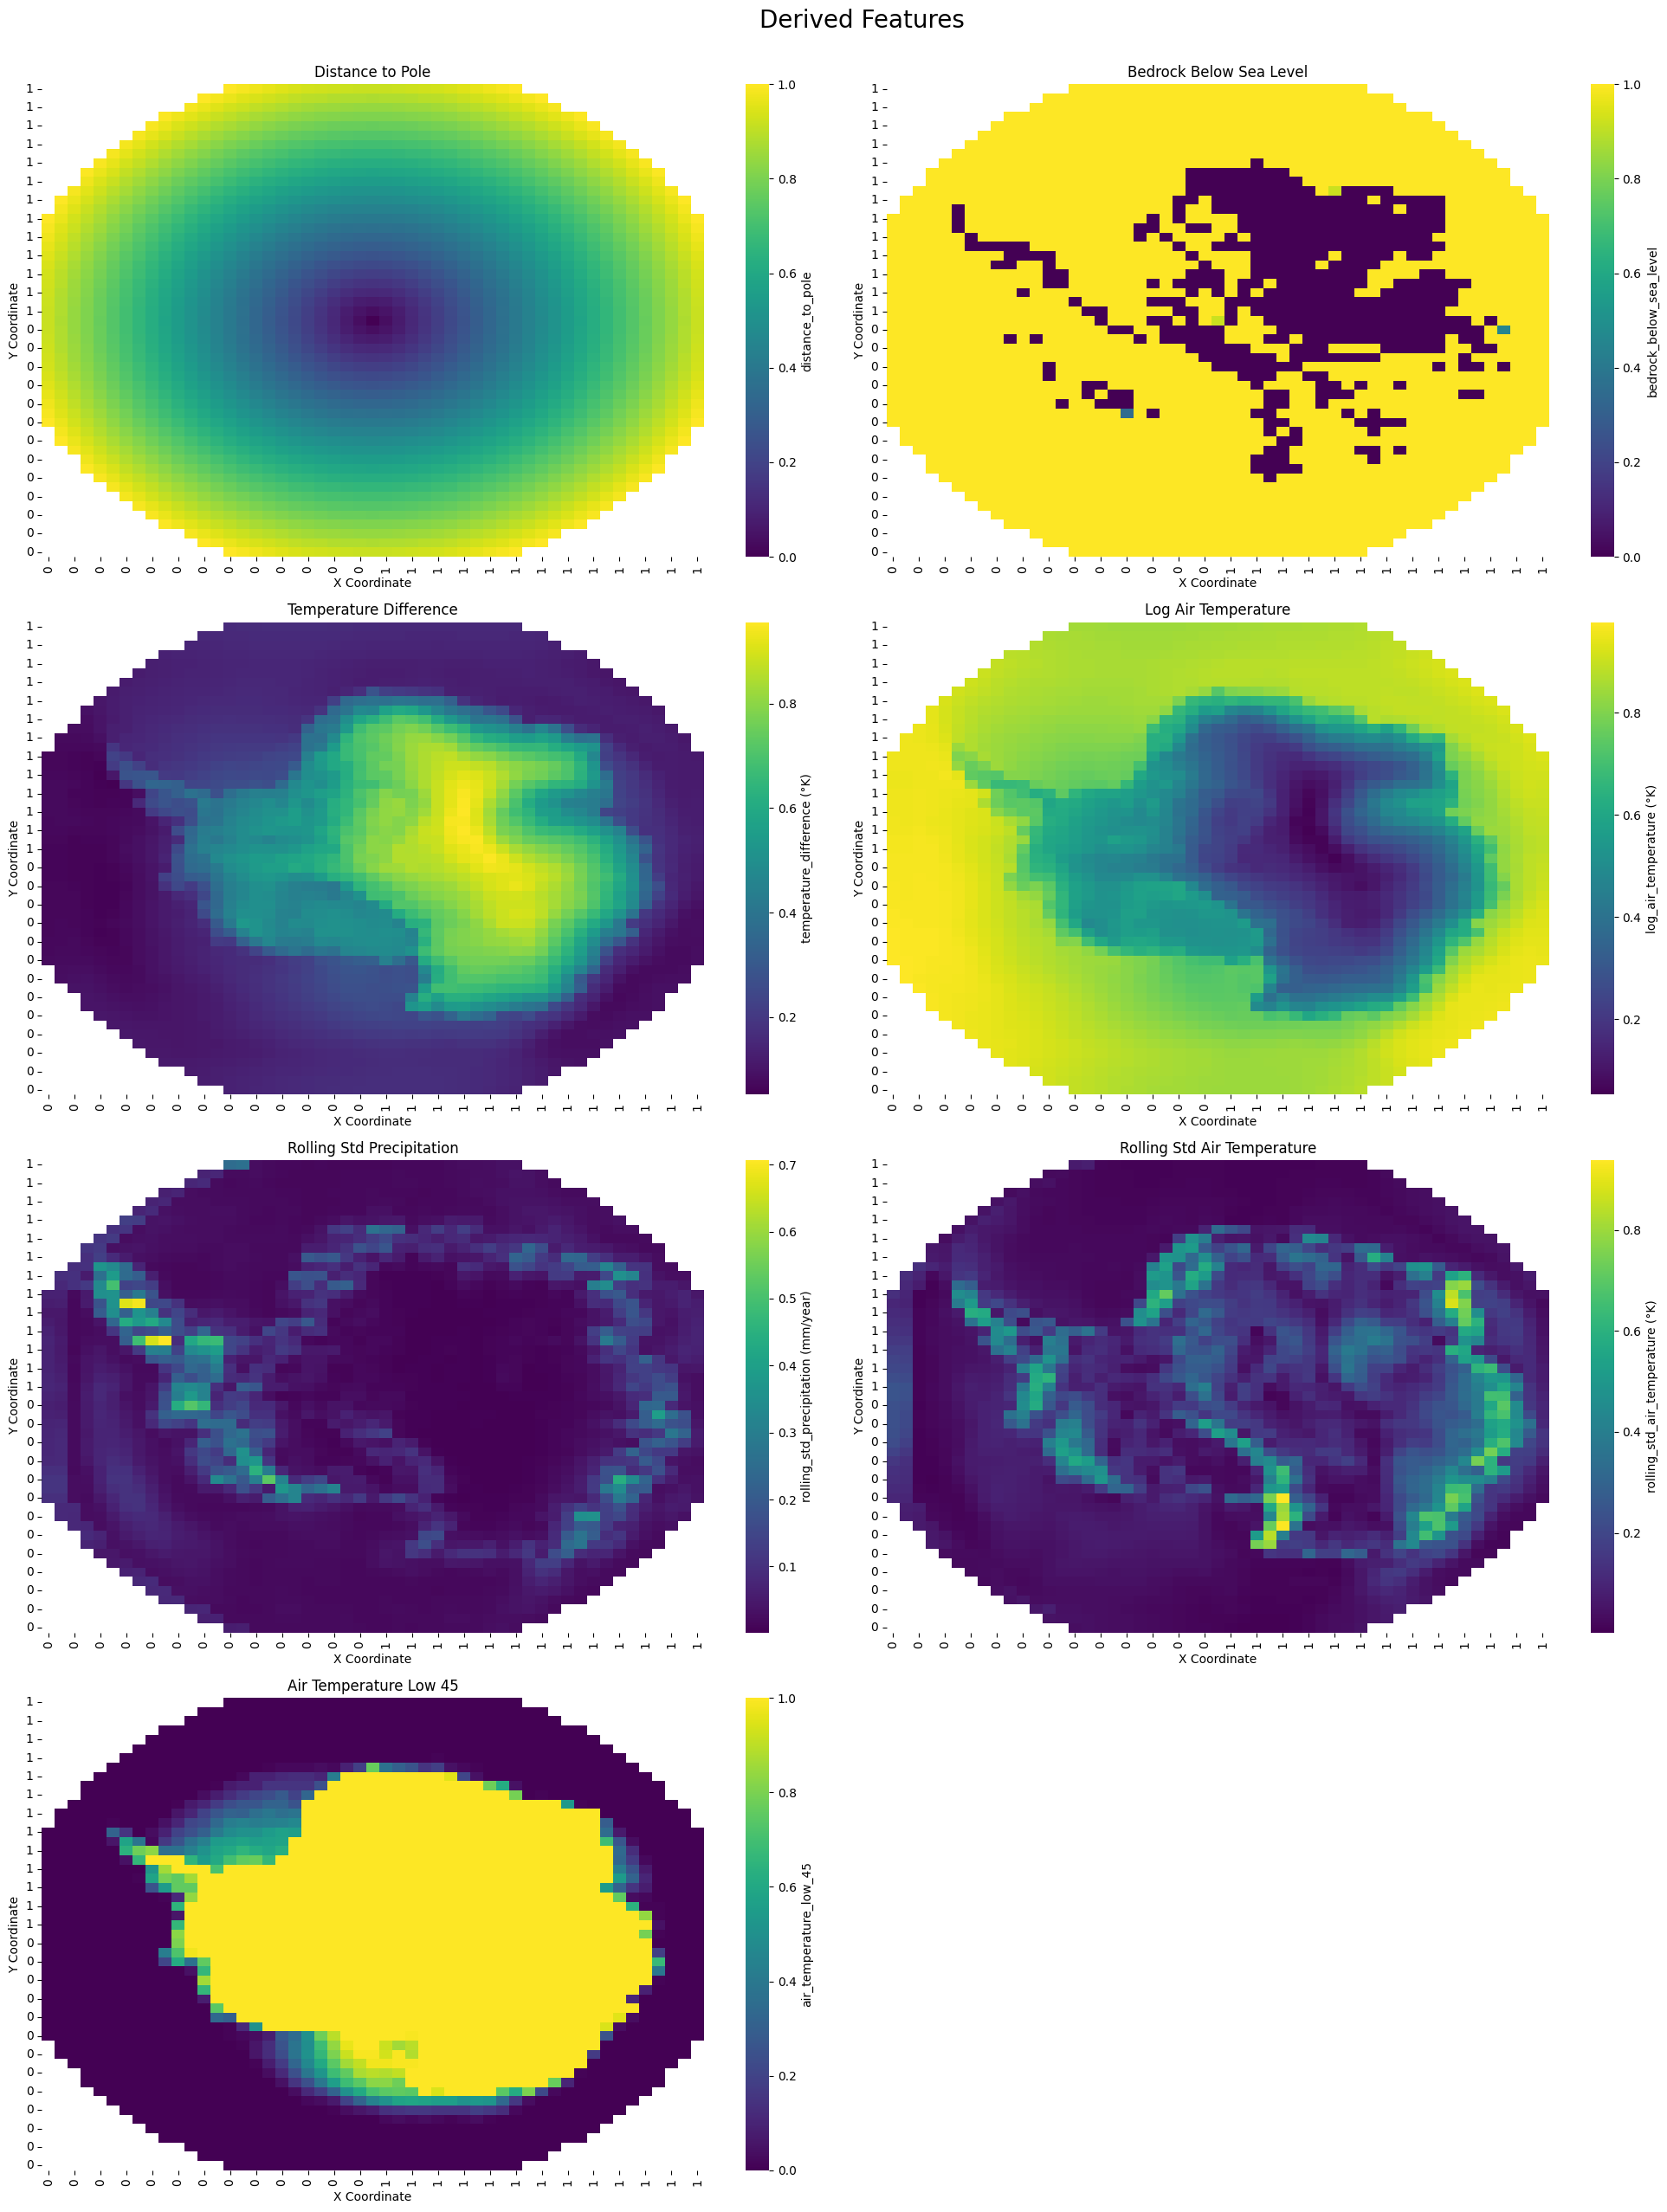

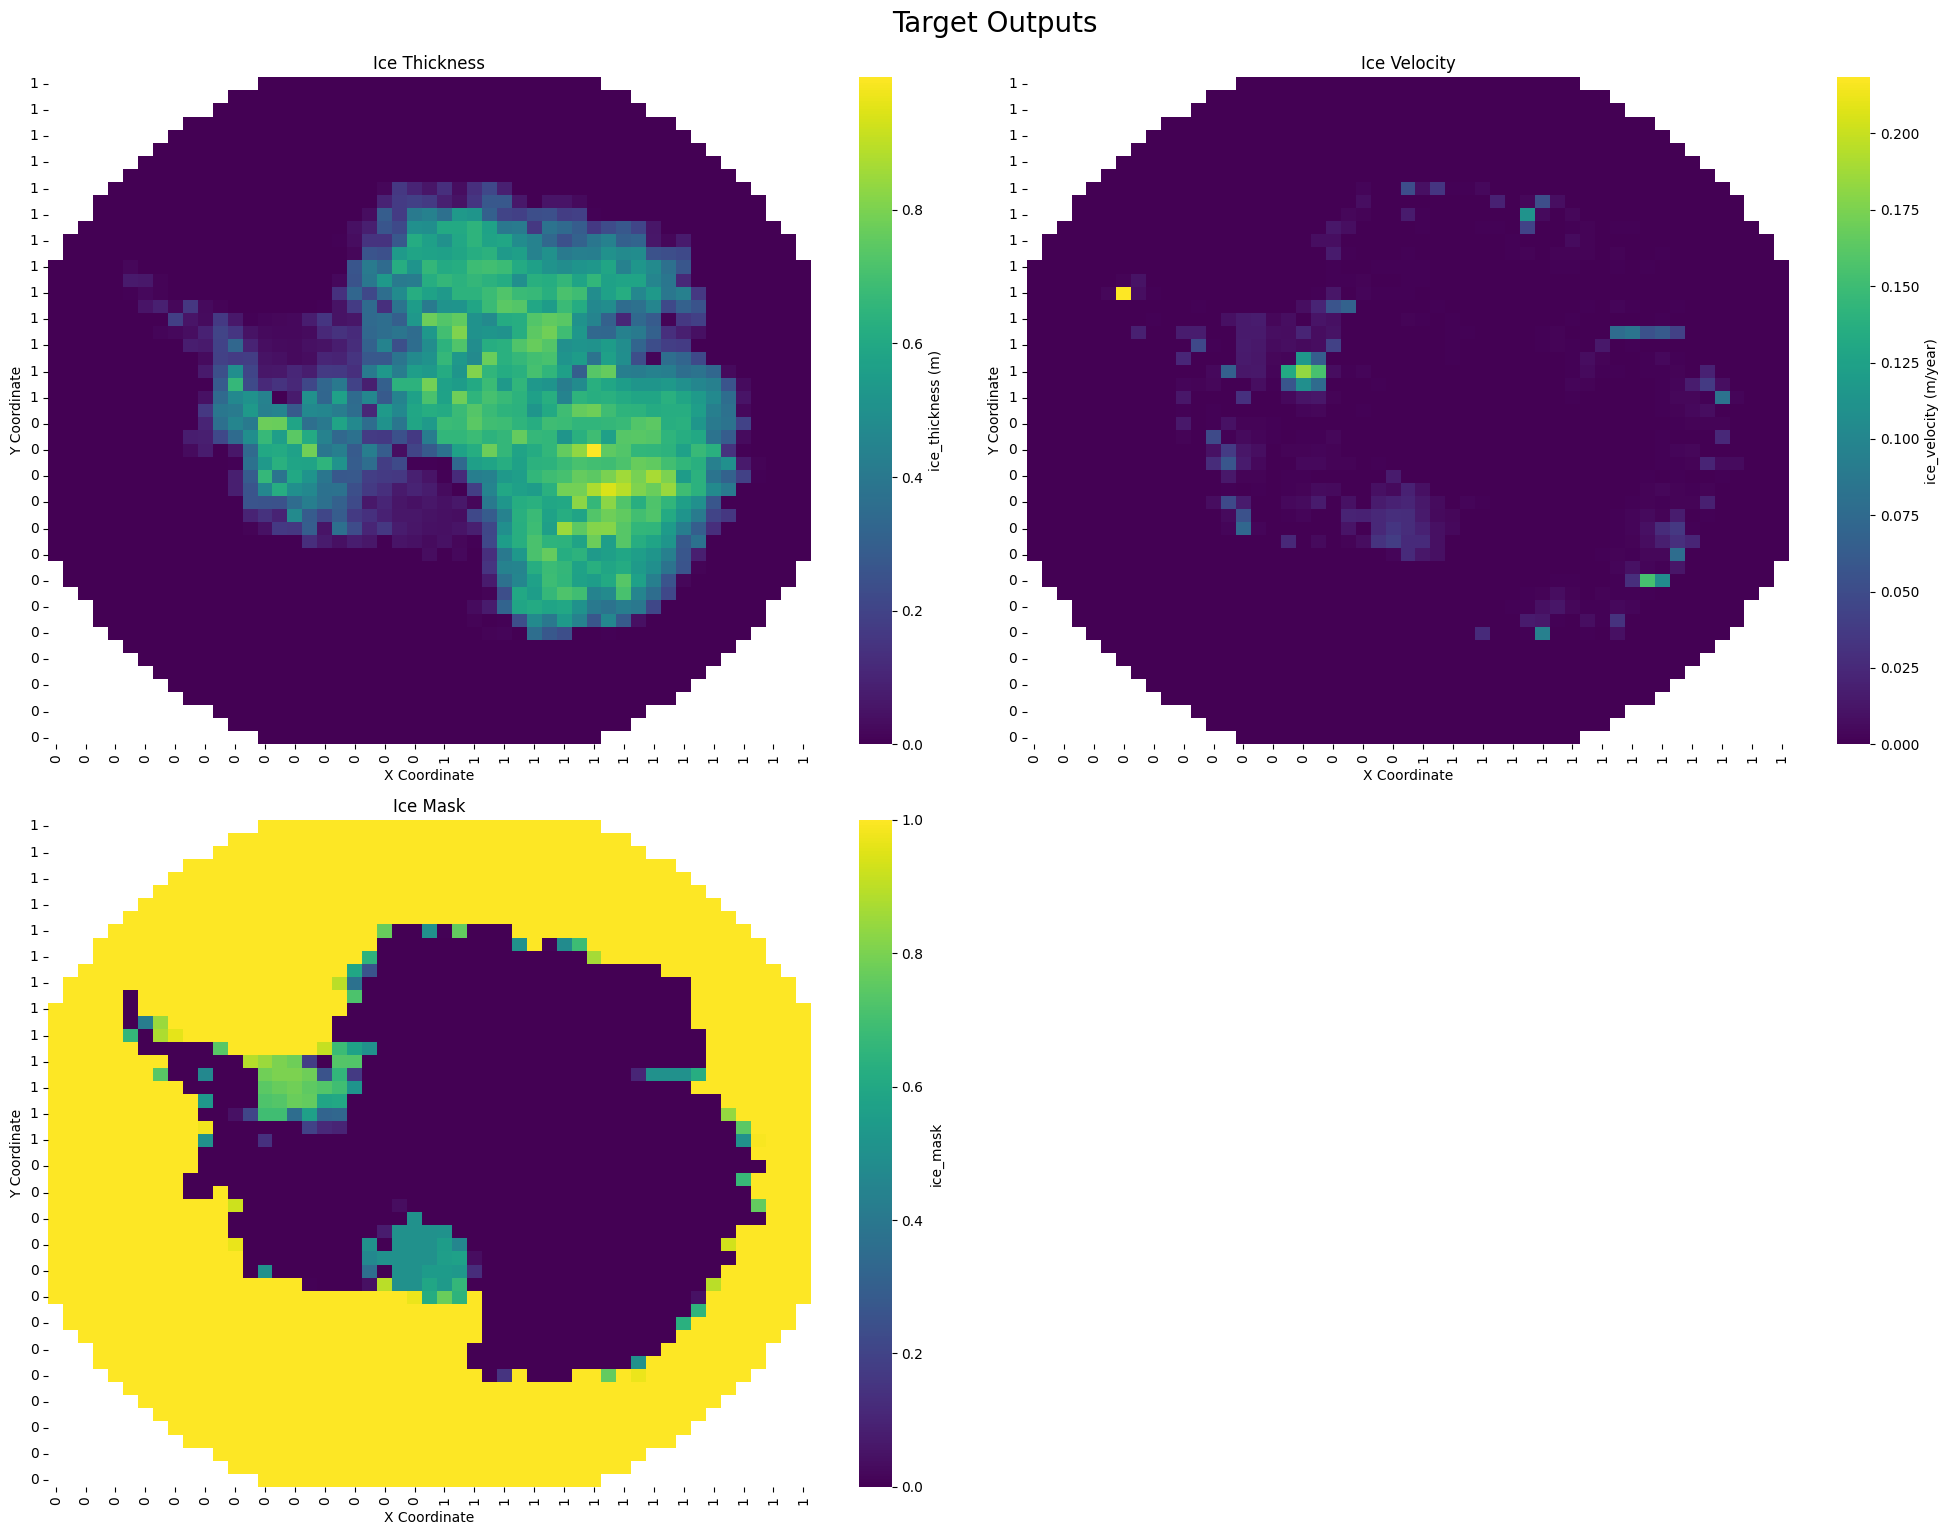

In [3]:
df_test = df[df['set'] == 'test'].copy()
df_test = rescale_features(df_test, test_scales)

input_features = ['bedrock_elevation', 'precipitation', 'air_temperature', 'ocean_temperature']
input_titles = ['Bedrock Elevation', 'Precipitation', 'Air Temperature', 'Ocean Temperature']
input_units = ['m', 'mm/year', '°K', '°K']

derived_features = ['distance_to_pole', 'bedrock_below_sea_level', 'temperature_difference', 
                    'log_air_temperature', 'rolling_std_precipitation', 'rolling_std_air_temperature', 
                    'air_temperature_low_45']
derived_titles = ['Distance to Pole', 'Bedrock Below Sea Level', 'Temperature Difference', 
                    'Log Air Temperature', 'Rolling Std Precipitation', 'Rolling Std Air Temperature', 
                    'Air Temperature Low 45']
derived_units = ['', '', '°K', '°K', 'mm/year', '°K', '']

target_features = ['ice_thickness', 'ice_velocity', 'ice_mask']
target_titles = ['Ice Thickness', 'Ice Velocity', 'Ice Mask']
target_units = ['m', 'm/year', '']

input_features = ['bedrock_elevation', 'precipitation', 'air_temperature', 'ocean_temperature']
input_titles = ['Bedrock Elevation', 'Precipitation', 'Air Temperature', 'Ocean Temperature']
input_units = ['m', 'mm/year', '°K', '°K']

derived_features = ['distance_to_pole', 'bedrock_below_sea_level', 'temperature_difference', 
                    'log_air_temperature', 'rolling_std_precipitation', 'rolling_std_air_temperature', 
                    'air_temperature_low_45']
derived_titles = ['Distance to Pole', 'Bedrock Below Sea Level', 'Temperature Difference', 
                    'Log Air Temperature', 'Rolling Std Precipitation', 'Rolling Std Air Temperature', 
                    'Air Temperature Low 45']
derived_units = ['', '', '°K', '°K', 'mm/year', '°K', '']

target_features = ['ice_thickness', 'ice_velocity', 'ice_mask']
target_titles = ['Ice Thickness', 'Ice Velocity', 'Ice Mask']
target_units = ['m', 'm/year', '']

input_plot = plot_group_averaged_spatial_heatmap(df, input_features, input_titles, input_units, figsize=(20, 15))
input_plot.suptitle('Input Features', fontsize=20, y=1.02)
input_plot.savefig('out/images/input_features_heatmaps.png', dpi=300, bbox_inches='tight')

derived_plot = plot_group_averaged_spatial_heatmap(df, derived_features, derived_titles, derived_units, figsize=(20, 25))
derived_plot.suptitle('Derived Features', fontsize=20, y=1.02)
derived_plot.savefig('out/images/derived_features_heatmaps.png', dpi=300, bbox_inches='tight')

target_plot = plot_group_averaged_spatial_heatmap(df, target_features, target_titles, target_units, figsize=(20, 15))
target_plot.suptitle('Target Outputs', fontsize=20, y=1.02)
target_plot.savefig('out/images/target_outputs_heatmaps.png', dpi=300, bbox_inches='tight')

plt.show()

## Broad Testing


### Single-Target


In [ ]:
broad_single_target_results = test_models(ALL_SINGLE_TARGET_MODELS, multi=False, cv=5, refined=False, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

### Multi-Target


In [ ]:
broad_multi_target_results = test_models(ALL_MULTI_TARGET_MODELS, multi=True, cv=5, refined=False, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## Refined Testing


### Single-Target


In [ ]:
refined_single_target_results = test_models(REFINED_SINGLE_TARGET_MODELS, multi=False, cv=5, refined=True, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

### Multi-Target


In [ ]:
refined_multi_target_results = test_models(REFINED_MULTI_TARGET_MODELS, multi=True, cv=5, refined=True, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## Sequential Models


## Genetic Programming


In [ ]:
best_model, train_metrics, test_metrics = apply_gp(X_train, X_test, y_train, y_test)
print("Best Model:", best_model)
print("Train Metrics:", train_metrics)
print("Test Metrics:", test_metrics)

## KAN


In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

In [ ]:
from kan import *
import torch
from kan.utils import create_dataset, ex_round

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert your data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64).to(device)

# Create a dataset dictionary
dataset = {
    'train_input': X_train_tensor,
    'train_label': y_train_tensor,
    'test_input': torch.tensor(X_test.values, dtype=torch.float64).to(device),
    'test_label': torch.tensor(y_test.values, dtype=torch.float64).to(device)
}


input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_dim = 10  # You can adjust this

model = KAN(width=[input_dim, hidden_dim, output_dim], grid=3, k=3, seed=42, device=device)

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.001)

model = model.prune()
model = model.refine(10)
model.fit(dataset, opt="LBFGS", steps=50)

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

formula = model.symbolic_formula()
for i, f in enumerate(formula[0]):
    print(f"Target {i+1}: {ex_round(f, 4)}")

predictions = model(dataset['test_input'])

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions.cpu().detach().numpy())
r2 = r2_score(y_test, predictions.cpu().detach().numpy())

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")